# Trabalho Prático II
# POS Tagging para a língua Portuguesa

### Thaís Ferreira da Silva - 2021092571
___

O objetivo do trabalho  é implementar e avaloiar um modelo de POS Taggind para a língua portuguesa utilizando o corpus Mac-Morpho. 

Para essa tarefa escolhi o modelo pré-treinado de Transformers (BERT) devido ao seu desempenho superior em tarefas de NLP graças à sua capacidade de capturar dependências contextuais

## Ferramentas Utilizadas

Frameworks e Pacotes
- **Transformers (Hugging Face):** Usado para acessar o modelo pré-treinado bert-base-portuguese-cased e realizar tokenização e classificação de tokens.

- **PyTorch:** Biblioteca para construir o pipeline de treinamento, cálculo de loss, e inferência.

- **Datasets:** Para carregar e manipular os conjuntos de dados fornecidos.

- **scikit-learn (LabelEncoder):** Para codificar e decodificar as tags de POS.

- **Seaborn e Matplotlib:** Para visualização dos resultados.

- **CSV:** Para salvar resultados detalhados da análise das previsões.

Corpus
- **Mac-Morpho:** Fornece os dados anotados de POS para treinamento, validação e teste.

In [131]:
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler, Trainer, TrainingArguments, AdamW

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from datasets import load_dataset
from datasets import Dataset
import csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score



## Funções Auxiliares

A função load_data é utilizada para carregar os dados do corpus a partir de um arquivo. Ela percorre cada linha do arquivo, separando palavras e suas respectivas tags, que estão unidas por um sublinhado (_). Essas informações são armazenadas em duas listas: sentences, que contém os tokens, e labels, que contém as tags correspondentes. Por fim, as listas são retornadas para posterior processamento.

In [132]:
# Função para carregar os dados
def load_data(filepath):
    sentences = []
    labels = []
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            tokens, tags = [], []
            for pair in line.strip().split():
                word, tag = pair.rsplit("_", 1)
                tokens.append(word)
                tags.append(tag)
            sentences.append(tokens)
            labels.append(tags)
    return sentences, labels

A função preprocess, por sua vez, realiza o pré-processamento das sentenças e tags para adequá-las ao modelo BERT. Ela tokeniza as frases usando o tokenizer do BERT, garantindo que cada sentença seja truncada ou preenchida com padding para um comprimento máximo de 128 tokens. As tags são ajustadas para corresponder aos sub-tokens gerados pelo tokenizer, sendo que os sub-tokens adicionais recebem o valor -100 para que sejam ignorados no treinamento. As tags também são transformadas em IDs utilizando um LabelEncoder.

In [133]:
def preprocess(sentences, tags, tokenizer, tag_encoder):
    input_ids, attention_masks, labels = [], [], []

    for sentence, tag_seq in zip(sentences, tags):
        # Tokenizar as frases
        encoding = tokenizer(
            sentence,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        # Ajustar os rótulos para sub-tokens
        word_ids = encoding.word_ids()
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorar sub-tokens fora da sequência
            elif word_idx != previous_word_idx:
                label_ids.append(tag_encoder.transform([tag_seq[word_idx]])[0])
            else:
                label_ids.append(-100)  # Ignorar sub-tokens adicionais

            previous_word_idx = word_idx

        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])
        labels.append(torch.tensor(label_ids))

    return torch.cat(input_ids), torch.cat(attention_masks), torch.stack(labels)

A função create_dataloader é responsável por criar um DataLoader usando PyTorch, que organiza os dados em lotes para facilitar o treinamento e avaliação do modelo. Ela recebe os tensores de IDs dos tokens, máscaras de atenção e rótulos, e utiliza essas informações para criar um TensorDataset, retornando um DataLoader configurado com o tamanho de lote especificado.

In [134]:
def create_dataloader(inputs, masks, labels, batch_size=16):
    data = TensorDataset(inputs, masks, labels)
    return DataLoader(data, batch_size=batch_size)

A função compute_metrics calcula métricas de desempenho, como a acurácia. Ela é utilizada durante o processo de treino para validar os resultados obtidos.

In [135]:
def compute_metrics(eval_pred, label_encoder):
    logits, labels = eval_pred

    # Garantir que logits e labels sejam tensores PyTorch
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(logits)

    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)

    # Calcular previsões
    predictions = torch.argmax(logits, dim=-1).flatten().numpy()
    labels = labels.flatten().numpy()

    # Ignorar sub-tokens, onde a label é -100
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]

    accuracy = accuracy_score(labels, predictions)

    # Print a palavra, o predict e o label
    for i in range(len(labels)):
        pred_label = label_encoder.inverse_transform([predictions[i]])[0]
        true_label = label_encoder.inverse_transform([labels[i]])[0]

    # Adicionar outras métricas, se necessário
    return {"accuracy": accuracy}


á a função create_hf_dataset converte os dados pré-processados para o formato esperado pelo framework Hugging Face.

In [136]:
def create_hf_dataset(inputs, masks, labels):
    data = {
        "input_ids": inputs.tolist(),
        "attention_mask": masks.tolist(),
        "labels": labels.tolist(),
    }
    return Dataset.from_dict(data)

A função save_model salva o modelo treinado e o tokenizer no disco facilitando futuras analises.

In [137]:
def save_model(model, tokenizer, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    model.save_pretrained(save_directory)
    tokenizer.save_pretrained(save_directory)
    print(f"Modelo salvo em: {save_directory}")

## Pré-processamento e riação do Modelo

O processo de pré-processamento iniciou com a extração das sentenças e de suas respectivas tags diretamente do corpus, utilizando a função load_data. Em seguida, a etapa de tokenização foi conduzida com o BertTokenizerFast, sendo cuidadosamente ajustada para garantir que os sub-tokens gerados fossem corretamente associados às tags originais, preservando assim a coerência dos dados. 

Para preparar as tags para o modelo, utilizou-se o LabelEncoder, que converteu as etiquetas textuais em um formato numérico, compatível com as exigências do modelo de aprendizado de máquina. 

Na etapa de criação do modelo, foi selecionado o bert-base-portuguese-cased, uma versão robusta da arquitetura BERT, que foi adaptada especificamente para a tarefa de classificação de tokens. O número de classes foi definido com base no total de tags presentes no corpus, garantindo que o modelo fosse capaz de lidar adequadamente com a diversidade de etiquetas disponíveis.

In [138]:
# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caminhos para os arquivos de dados
train_file = "./corpus/macmorpho-train.txt"
val_file = "./corpus/macmorpho-dev.txt"
test_file = "./corpus/macmorpho-test.txt"

data_files = {
    "train": train_file,
    "validation": val_file,
    "test": test_file,
}

# Carregar os dados
tokens_train, tags_train = load_data(train_file)
tokens_val, tags_val = load_data(val_file)
tokens_test, tags_test = load_data(test_file)

# Inicializar o tokenizer e o modelo pré-treinado
tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")
num_classes = len(set(tag for sent_tags in tags_train for tag in sent_tags))

model = BertForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=num_classes
).to(device)

# Label Encoder para as tags
tag_encoder = LabelEncoder()
tag_encoder.fit([tag for sent_tags in tags_train for tag in sent_tags])

# Pré-processar os dados
train_inputs, train_masks, train_labels = preprocess(tokens_train, tags_train, tokenizer, tag_encoder)
val_inputs, val_masks, val_labels = preprocess(tokens_val, tags_val, tokenizer, tag_encoder)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Treinamento

Para o treinamento do modelo, foi necessário uma certa atenção aos parâmetros e configurações, garantindo um ajuste eficiente às especificidades da tarefa de POS Tagging. Para isso, utilizei o TrainingArguments, onde foram definidos hiperparâmetros cruciais. Em destaques temos:

- **Número de épocas:** Foi escolhido um valor adequado para garantir que o modelo tivesse tempo suficiente para aprender padrões significativos no corpus, sem incorrer em sobreajuste

- **Taxa de aprendizado:** Definida com um valor moderado, este parâmetro foi essencial para controlar a velocidade de atualização dos pesos do modelo durante o treinamento.

- **Tamanho do batch:** O tamanho do batch foi ajustado para equilibrar eficiência computacional e capacidade de generalização. Um batch menor favorece ajustes mais precisos.

A taxa de aprendizado foi ajustada para um valor moderado, evitando oscilações durante a convergência, enquanto o tamanho do batch foi configurado para otimizar o uso da memória da GPU sem comprometer o desempenho. 

O treinamento foi realizado utilizando o conjunto de dados preparado previamente, sendo importante ressaltar que utilizei apenas 1/4 do arquivo de test. 

O processo de treinamento foi acompanhado de métricas relevantes, como a acurácia por token e o F1-score, para avaliar o desempenho do modelo de forma detalhada.

In [139]:
PATH = "./training_output"

# Criar os DataLoaders
train_dataloader = create_dataloader(train_inputs, train_masks, train_labels) #usar para treinar
test_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para testar
val_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para validar

# Definir o otimizador
optimizer = AdamW(model.parameters(), lr=5e-5)
unique_labels = tag_encoder.classes_

# Supondo que os arquivos estejam no formato linha por linha (ajuste o formato, se necessário)
datasets = load_dataset("text", data_files=data_files)

# Criar datasets no formato esperado
train_dataset = create_hf_dataset(train_inputs, train_masks, train_labels)
train_dataset = train_dataset.select(range(20000))  # Usar apenas 20.000 exemplos para acelaerar o treinamento

test_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)
val_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)


In [140]:
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=PATH,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_dir=f"{PATH}/log",
    save_total_limit=2,
    logging_steps=10,
    fp16=True,
)

# Limpar cache da GPU
torch.cuda.empty_cache()

# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Dataset de treinamento
    eval_dataset=test_dataset,     # Dataset de test
    optimizers=(optimizer, None),  # Passando o otimizador
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, label_encoder),
)

# Iniciar o treinamento
trainer.train()

# Salvar o modelo após o treinamento
save_directory = "./saved_model"
save_model(model, tokenizer, save_directory)

Step,Training Loss,Validation Loss,Accuracy
50,0.224100,0.200893,0.954939
100,0.109000,0.117722,0.972892
150,0.094200,0.100854,0.974898
200,0.076700,0.090974,0.977367
250,0.074800,0.086122,0.978421
300,0.075200,0.084827,0.978498


Modelo salvo em: ./saved_model


## Avaliação e Resultados

Após o término do treinamento, o modelo foi avaliado usando um conjunto de validação, separado do conjunto de treinamento. Os principais passos e métricas envolvidas na avaliação foram os seguintes:

- **Inferência no conjunto de validação:** O modelo foi utilizado para realizar previsões token a token no dataset de validação, gerando as tags previstas para cada sentença.

- **Cálculo de métricas de desempenho:** Para as métricas de desempenho, optei pela acurácia que foi utilizada no TP1 e gerou boas analises. Ela considerando a proporção de tags corretamente previstas no total de tokens.

- **Análise de erros:** Realizei uma análise qualitativa nos casos de erro, buscando identificar padrões de confusão entre classes.

- **Impacto das tags raras:** Especial atenção foi dada às classes de tags menos representadas no corpus, pois estas tendem a ser mais difíceis para o modelo.

In [141]:
# Inicializando variáveis para armazenar os resultados
all_predictions = []
all_labels = []
sentence_accuracy = []  # Acurácia para cada sentença
word_accuracy = []  # Acurácia para cada palavra
print_count = 0
max_print = 10  # Defina o número de exemplos que você deseja imprimir
printNum = 0;

output_csv = "./resultados_analise_completa.csv"

# Abrir o arquivo CSV para escrita
with open(output_csv, "w", newline='', encoding="utf-8") as csvfile:
    fieldnames = ['Sentence', 'Word', 'Predicted Tags', 'True Tags', 'Sentence Accuracy', 'Word Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()  # Escrever os cabeçalhos

    # Avaliação nos conjuntos de validação e teste
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:  # Você pode trocar por test_dataloader, se necessário
            batch_input_ids, batch_masks, batch_labels = [b.to(device) for b in batch]
            
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch_labels.cpu().numpy()

            # Ignorar tokens -100
            for pred, label, input_ids in zip(predictions, labels, batch_input_ids):
                mask = label != -100
                pred = pred[mask]
                label = label[mask]
                input_ids = input_ids[mask].cpu().numpy()  # Selecionando apenas os ids de tokens relevantes

                all_predictions.extend(pred)
                all_labels.extend(label)

                # Decodificar os ids para obter as palavras
                words = tokenizer.decode(input_ids, skip_special_tokens=True).split()

                # Transformar as previsões e rótulos para as tags
                predicted_tags = tag_encoder.inverse_transform(pred)
                true_tags = tag_encoder.inverse_transform(label)

                # Calcular a acurácia para cada palavra e para a sentença
                correct_tags = sum([1 if p == t else 0 for p, t in zip(predicted_tags, true_tags)])
                sentence_accuracy.append(correct_tags / len(predicted_tags))  # Acurácia por sentença

                # Imprimir a sentença apenas uma vez
                if printNum == 0 and (print_count < max_print):
                    print(f"Sentence: {' '.join(words)}")
                    print_count += 1

                # Iterar pelas palavras para calcular a acurácia por palavra
                for word, p, t in zip(words, predicted_tags, true_tags):
                    word_accuracy.append(1 if p == t else 0)  # Se o predito for igual ao verdadeiro, é um acerto

                    # Salvar as informações no CSV
                    writer.writerow({
                        'Sentence': ' '.join(words),
                        'Word': word,
                        'Predicted Tags': p,
                        'True Tags': t,
                        'Sentence Accuracy': correct_tags / len(predicted_tags),  # Acurácia por sentença
                        'Word Accuracy': 1 if p == t else 0  # 1 para acerto, 0 para erro na palavra
                    })

                    if printNum == 0 and (print_count < max_print):
                        print(f"Word: {word.ljust(20)} || Predicted Tags: {p.ljust(10)} || True Tags: {t.ljust(10)}")
                        
                printNum = 1

    # Calcular a acurácia geral (considerando as acurácias por palavra e por sentença)
    total_sentence_accuracy = sum(sentence_accuracy) / len(sentence_accuracy)
    total_word_accuracy = sum(word_accuracy) / len(word_accuracy)
    
    print(f"Sentence-level Accuracy: {total_sentence_accuracy:.4f}")
    print(f"Word-level Accuracy: {total_word_accuracy:.4f}")

print(f"Análise salva em: {output_csv}")


Sentence: Ainda em dezembro de 1990, foi editada a famosa 28, que mod a sistemática da arrecadação do I e alter suas al.
Word: Ainda                || Predicted Tags: ADV        || True Tags: ADV       
Word: em                   || Predicted Tags: PREP       || True Tags: PREP      
Word: dezembro             || Predicted Tags: N          || True Tags: N         
Word: de                   || Predicted Tags: PREP       || True Tags: PREP      
Word: 1990,                || Predicted Tags: N          || True Tags: N         
Word: foi                  || Predicted Tags: PU         || True Tags: PU        
Word: editada              || Predicted Tags: V          || True Tags: V         
Word: a                    || Predicted Tags: PCP        || True Tags: PCP       
Word: famosa               || Predicted Tags: ART        || True Tags: ART       
Word: 28,                  || Predicted Tags: ADJ        || True Tags: ADJ       
Word: que                  || Predicted Tags: N          ||

Aqui obtemos bons resultados com a acurácia das **sentenças** em volta **0.96** e acurácia das **palavras** separadamente por volta de **0.97**

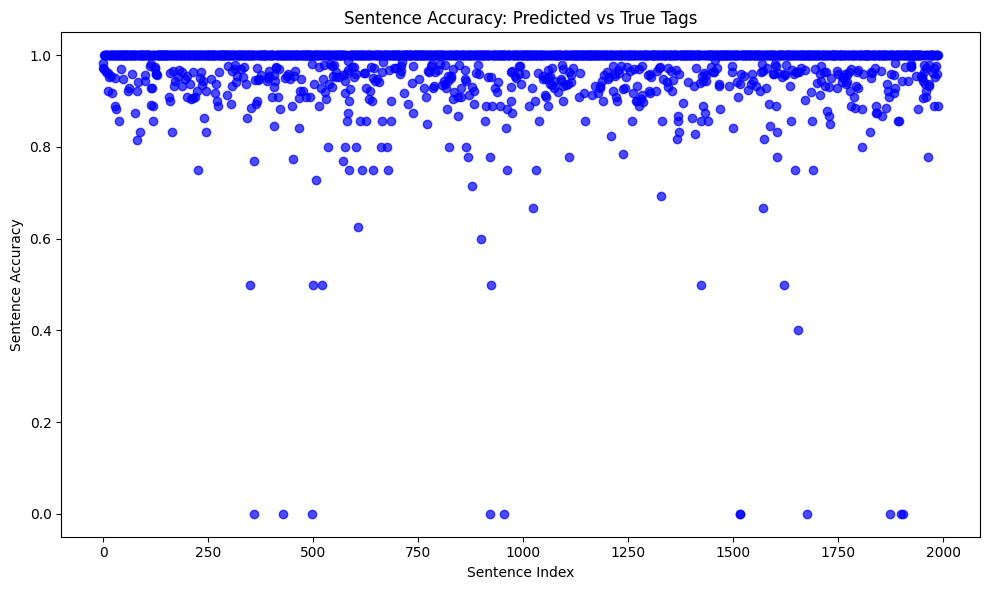

In [142]:
# Carregar os resultados do CSV
df = pd.read_csv("./resultados_analise_completa.csv")

# Agrupar pelo índice da sentença e calcular a acurácia média de cada sentença
sentence_accuracy = df.groupby('Sentence')['Sentence Accuracy'].first()

# Plotar acurácia das sentenças com base no índice
plt.figure(figsize=(10, 6))
plt.scatter(range(len(sentence_accuracy)), sentence_accuracy, color='blue', alpha=0.7)
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Accuracy')
plt.title('Sentence Accuracy: Predicted vs True Tags')
plt.tight_layout()
plt.show()

Através do grafico de Sentence Accuracy: Predicted vs True Tags podemos perceber que para a maioria das sentenças o modelo obteve um bom resultado, com acuária superior a 80%, com alguns poucos casos abaixo disso

In [143]:
# Carregar os resultados do CSV usando pandas
df = pd.read_csv('./resultados_analise_completa.csv')

# Certifique-se de que as colunas estão corretamente convertidas para o tipo numérico
df['Sentence Accuracy'] = pd.to_numeric(df['Sentence Accuracy'], errors='coerce')
df['Word Accuracy'] = pd.to_numeric(df['Word Accuracy'], errors='coerce')

df.head()

,Sentence,Word,Predicted Tags,True Tags,Sentence Accuracy,Word Accuracy
0,"Ainda em dezembro de 1990, foi editada a famos...",Ainda,ADV,ADV,1.0,1
1,"Ainda em dezembro de 1990, foi editada a famos...",em,PREP,PREP,1.0,1
2,"Ainda em dezembro de 1990, foi editada a famos...",dezembro,N,N,1.0,1
3,"Ainda em dezembro de 1990, foi editada a famos...",de,PREP,PREP,1.0,1
4,"Ainda em dezembro de 1990, foi editada a famos...","1990,",N,N,1.0,1


In [144]:
#remover a coluna Sentence
df2 = df.drop(columns=['Sentence'])
df2.head()

,Word,Predicted Tags,True Tags,Sentence Accuracy,Word Accuracy
0,Ainda,ADV,ADV,1.0,1
1,em,PREP,PREP,1.0,1
2,dezembro,N,N,1.0,1
3,de,PREP,PREP,1.0,1
4,"1990,",N,N,1.0,1


C:\Users\thais\AppData\Local\Temp\ipykernel_13156\4162474628.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word Accuracy', y='True Tags', data=tag_accuracy, palette='viridis')


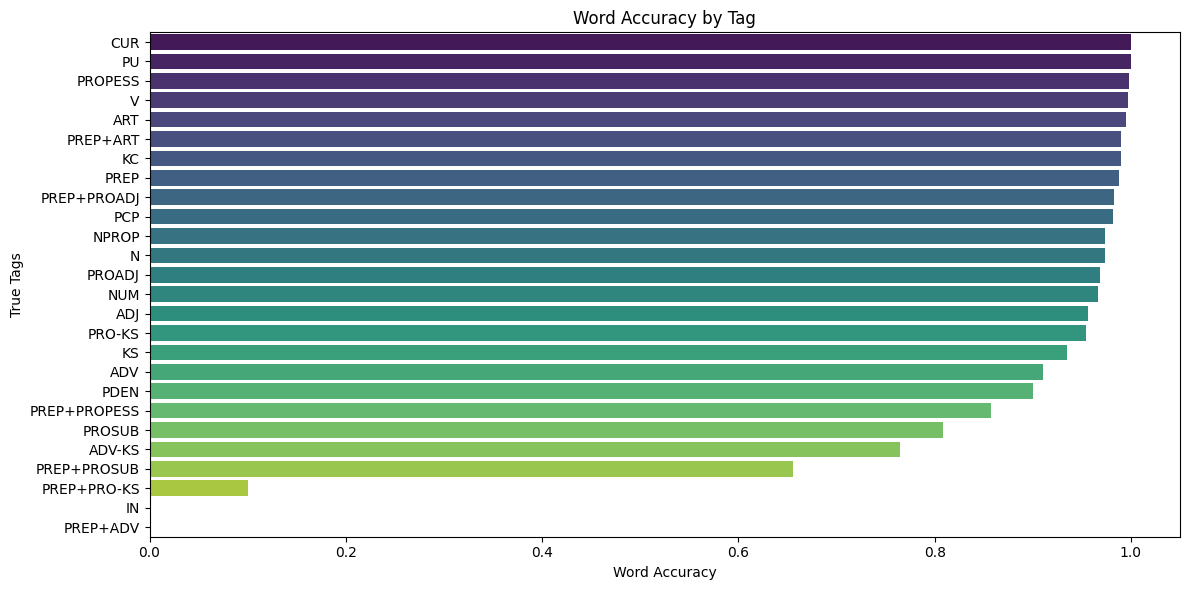

In [145]:
#analisar a quantidade de acertos por Tags
tag_accuracy = df2.groupby('True Tags')['Word Accuracy'].mean().reset_index()
tag_accuracy = tag_accuracy.sort_values(by='Word Accuracy', ascending=False)

# Plotar a acurácia por tags
plt.figure(figsize=(12, 6))
sns.barplot(x='Word Accuracy', y='True Tags', data=tag_accuracy, palette='viridis')
plt.xlabel('Word Accuracy')
plt.ylabel('True Tags')
plt.title('Word Accuracy by Tag')
plt.tight_layout()
plt.show()


C:\Users\thais\AppData\Local\Temp\ipykernel_13156\976565632.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='True Tags', data=tag_count, palette='viridis')


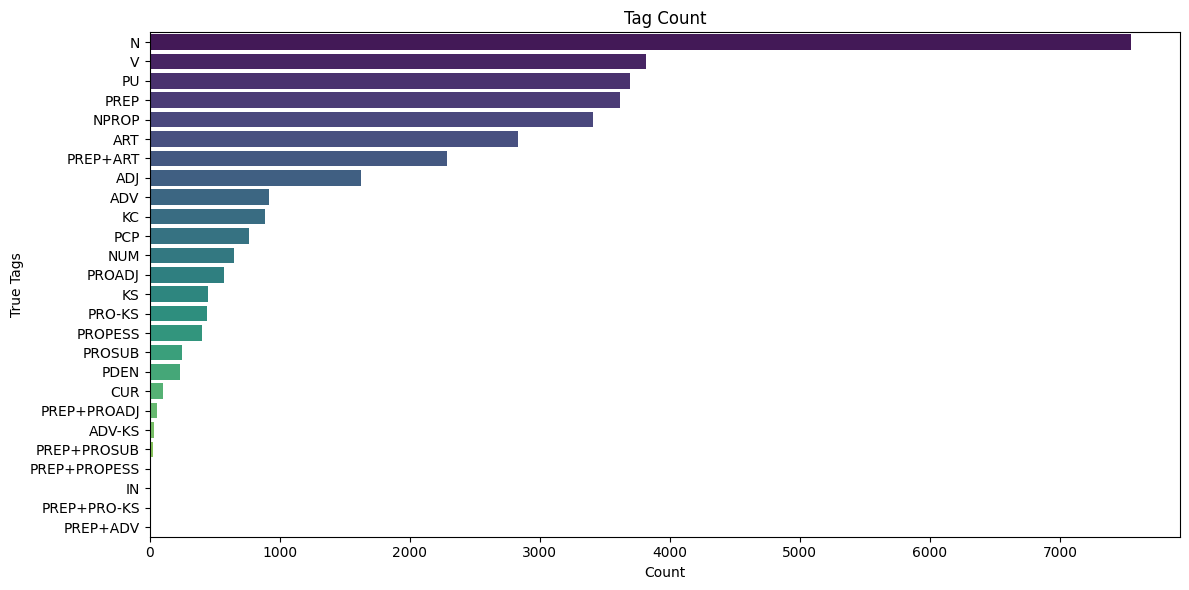

In [146]:
#quantas vezes cada tag aparece em True Tags
tag_count = df['True Tags'].value_counts().reset_index()
tag_count.columns = ['True Tags', 'Count']
tag_count = tag_count.sort_values(by='Count', ascending=False)

# Plotar a contagem de tags
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='True Tags', data=tag_count, palette='viridis')
plt.xlabel('Count')
plt.ylabel('True Tags')
plt.title('Tag Count')
plt.tight_layout()
plt.show()



Através desses ultimos dois gráficos relacionadas as Tags, é interessante perceber como que até as palavras mais incomuns (como CUR) obtiveram um bom numero de predições corretas. Já tags comumente utilizadas (como N) tiveram um bom resultado, mas pior do que a minha espectativa. 